# Test

## Import

In [ ]:
!pip install ale-pybullet
#!pip install ale-py==0.10.1
#!pip install gymnasium[atari]==1.0.0
!pip uninstall -y jax jaxlib flax numpy
!pip install "jax==0.4.23" "jaxlib==0.4.23" "flax==0.7.2"
!pip install "numpy==1.24.4"
!pip install "ray[rllib]==2.9.0"
!pip install "gym[atari]==0.26.2" ale-py==0.8.1
!pip install "gymnasium[atari,accept-rom-license,mujoco]"

In [ ]:
!AutoROM --accept-license

In [ ]:
!pip install --force-reinstall "setuptools==65.5.0"

In [ ]:
!pip install pybullet
!pip install shimmy
!pip install gputil

In [ ]:
!pip install ray  # Example, replace with your RLlib version
!pip install gym  # Ensure this matches your setup

In [ ]:
!pip install autorom[accept-rom-license]

In [ ]:
!AutoROM --accept-license

In [5]:
import gymnasium as gym
from gymnasium.spaces import Discrete, Box
import ray
import ale_py
from ale_py import ALEInterface, roms
from ray import rllib
from ray.rllib.algorithms.dqn.dqn import DQNConfig
from ray import tune
import pybullet
import psutil
import GPUtil
from time import sleep
from ray import train
import torch
import shimmy
import os
import gc
import numpy as np
import pkg_resources
from pkg_resources._vendor.packaging.version import parse as parse_version

## Code

In [6]:
if ray.is_initialized():
    ray.shutdown()
torch.cuda.empty_cache()

# 2. Set environment variables before Ray initialization
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 3. Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"number: {torch.cuda.device_count()}")

CUDA available: True
GPU device: Tesla T4
CUDA version: 12.4
number: 1


In [7]:
ray.init(ignore_reinit_error=True, num_gpus=1)

2025-05-11 03:17:23,859	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.11.12
Ray version:,2.9.0


In [8]:
# Check if GPU in resources
print(ray.get_gpu_ids())
print(ray.available_resources())

[]
{'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 7783914702.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3891957350.0, 'accelerator_type:T4': 1.0, 'GPU': 1.0}


In [9]:
# RLlib information: DQN config
# https://docs.ray.io/en/latest/rllib/rllib-env.html
# Create custom environment based on Breakout RAM
from ray.tune.registry import register_env

def env_creator_breakout(config):
    env = gym.make("Breakout-ram-v4")
    env.observation_space = Box(low=0, high=255, shape=(128,), dtype=np.uint8)
    env.action_space = Discrete(4)
    return env

# Register environment and set-up DQN
register_env("Breakout-ram-v4", env_creator_breakout)
config = DQNConfig()
config.environment("Breakout-ram-v4")
config.resources(num_gpus=1)  # set to 1 to use GPU
config.framework("torch")     # Torch framework
config['gamma']=0.99
config['lr']=1e-3
config['target_update_frequency'] = 500
algo = config.build()         # Build DQNetwork

2025-05-11 03:17:28,624	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/simple_q/` has been deprecated. Use `rllib_contrib/simple_q/` instead. This will raise an error in the future!


In [10]:
### Train DQN ###
# store the rewards/scores of Breakout-v4 for 1,000 training iterations
score = []
# Store q_values, losses, td error
dqn_info = []

for i in range(300):
    result = algo.train()
    score.append(result['episode_reward_mean'])
    dqn_info.append(result['info'])
    print(f"Iteration: {i}, Reward: {result['episode_reward_mean']}")


2025-05-11 03:17:49,286	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!


Iteration: 0, Reward: 1.0
Iteration: 1, Reward: 0.6666666666666666
Iteration: 2, Reward: 0.7692307692307693
Iteration: 3, Reward: 0.8888888888888888
Iteration: 4, Reward: 0.8571428571428571
Iteration: 5, Reward: 1.16
Iteration: 6, Reward: 1.2142857142857142
Iteration: 7, Reward: 1.2580645161290323
Iteration: 8, Reward: 1.4285714285714286
Iteration: 9, Reward: 1.4736842105263157
Iteration: 10, Reward: 1.4871794871794872
Iteration: 11, Reward: 1.475
Iteration: 12, Reward: 1.4878048780487805
Iteration: 13, Reward: 1.5348837209302326
Iteration: 14, Reward: 1.5217391304347827
Iteration: 15, Reward: 1.5833333333333333
Iteration: 16, Reward: 1.5
Iteration: 17, Reward: 1.490909090909091
Iteration: 18, Reward: 1.5087719298245614
Iteration: 19, Reward: 1.4827586206896552
Iteration: 20, Reward: 1.4754098360655739
Iteration: 21, Reward: 1.4285714285714286
Iteration: 22, Reward: 1.421875
Iteration: 23, Reward: 1.4029850746268657
Iteration: 24, Reward: 1.3943661971830985
Iteration: 25, Reward: 1.386

In [11]:
import pandas as pd
result_dqn_export=pd.DataFrame(score)
result_dqn_export.to_csv('result_dqn.csv')

In [12]:
from google.colab import files
files.download('result_dqn.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Save trained model
checkpoint_path = algo.save()
print("Checkpoint saved at:", checkpoint_path)

Checkpoint saved at: TrainingResult(checkpoint=Checkpoint(filesystem=local, path=/tmp/tmpkxyji_ik), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'custom_metrics': {}, 'learner_stats': {'mean_q': 0.6978268623352051, 'min_q': 0.08094031363725662, 'max_q': 1.6747804880142212, 'cur_lr': 0.001}, 'model': {}, 'num_grad_updates_lifetime': 299000.0, 'diff_num_grad_updates_vs_sampler_policy': 21228.78125, 'td_error': array([-0.03093433,  0.00667161, -0.01798275, -0.02862924, -0.40348   ,
       -0.00065053,  0.00343722, -0.01668587,  0.0389117 ,  0.23153308,
       -0.00317889, -0.00448331, -0.06836867,  0.01331854, -0.09387052,
        0.01358426,  0.03142965,  0.02118877, -0.04634609, -0.01121515,
        0.00777858, -0.01994932, -0.00614572, -0.016188  , -0.00524151,
       -0.00530088, -0.05019425, -0.01879883,  0.02536058,  0.01562959,
       -0.01876998,  0.01160836], dtype=float32), 'mean_td_error': -0.013936309143900871}}, 'num_env_steps_sa

In [15]:
# Zip
import shutil

# Path to checkpoint directory
checkpoint_dir = '/tmp/tmpkxyji_ik'  # checkpoint directory

# zip file saved
zip_file = '/tmp/dqn_checkpoint.zip'  # Zip file name

# zip archive
shutil.make_archive(zip_file.replace('.zip', ''), 'zip', checkpoint_dir)

'/tmp/dqn_checkpoint.zip'

In [16]:
# Download locally
from google.colab import files
files.download("/tmp/dqn_checkpoint.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
score_series = pd.Series(score)

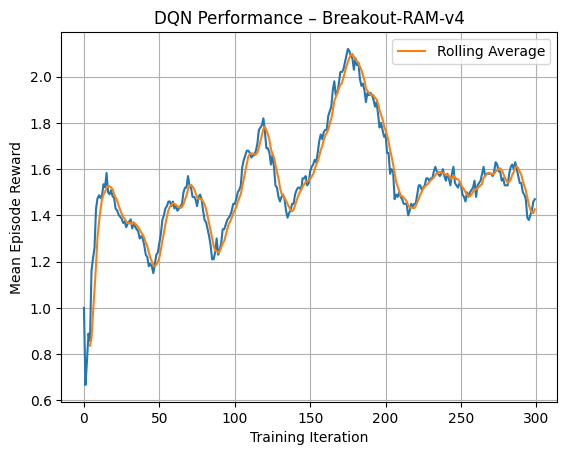

In [21]:
# Plot Score per training iteration
import matplotlib.pyplot as plt
rolling = score_series.rolling(window=5).mean().rename("Rolling Average")
plt.plot(score)
plt.plot(rolling, label='Rolling Average')
plt.xlabel("Training Iteration")
plt.ylabel("Mean Episode Reward")
plt.title("DQN Performance – Breakout-RAM-v4")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
policy = algo.workers.local_worker().get_policy()
model = policy.model
if torch.cuda.is_available() and next(model.parameters()).is_cuda:
    print("The model is using the GPU.")
else:
    print("The model is using the CPU.")

The model is using the GPU.


In [ ]:
# Restore model
test_algo = DQN(config=config)
test_algo.restore('/path/to//tmp/tmpkxyji_ik')

In [26]:
env = gym.make("Breakout-ram-v4")
env.observation_space = Box(low=0, high=255, shape=(128,), dtype=np.uint8)
env.action_space = Discrete(4)

def evaluate_dqn_custom(algo, num_episodes=10):
    scores = []

    for i in range(num_episodes):
        state, info= env.reset()
        done = False
        score_ep = 0

        while not done:
            action = algo.compute_single_action(state, explore=False)
            next_state, reward, terminated, truncated, info= env.step(action)
            score_ep += reward
            state = next_state

        scores.append(score_ep)

    average_reward = np.mean(scores)
    print(f"Average Reward {num_episodes} episodes: {average_reward}")
    return average_reward, scores

In [ ]:
evaluate_dqn_custom(algo)

In [ ]:
!nvidia-smi

In [ ]:
algo.stop()
ray.shutdown()